# Shoreline Change Extraction using Band Ratio

In [1]:
import planetary_computer as pc
import pystac_client
from pystac.extensions.projection import ProjectionExtension as proj
import stackstac

import numpy as np
import xarray as xr
import os

import matplotlib.pyplot as plt
import geopandas as gpd
import json

from shapely.geometry import shape
import rioxarray
from rasterio.crs import CRS
from rasterio.plot import show
import rasterio.features

from dask_gateway import GatewayCluster
from dask.distributed import Client, progress
import dask

### Dask Cluster

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': False})
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
client = cluster.get_client()
cluster.adapt(minimum=10, maximum=100)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.cafda70fc7d74af0b6bf7be6469812e7/status


### Area of Interest

In [3]:
aoi = 'nauru'
local =  gpd.read_file(aoi + '.geojson')
area_of_interest = local.geometry[0]
local.explore()

### Request Multispectal Data (S2 or L8)

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

search = catalog.search(
    intersects=area_of_interest,
    datetime="2021-01-01/2022-03-30",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 1.0}}, #cloudcover_percentage
)

raw_items = search.get_items()

count = 0
for item in raw_items:    
    print(f"{item.id}: {item.datetime} Cloud : {item.properties['eo:cloud_cover']}")
    count = count + 1
print(f"{count} Items")

S2A_MSIL2A_20211120T232621_R044_T58MGE_20211121T075719: 2021-11-20 23:26:21.024000+00:00 Cloud : 0.994915
S2A_MSIL2A_20210812T232621_R044_T58MGE_20210813T052643: 2021-08-12 23:26:21.024000+00:00 Cloud : 0.488811
S2B_MSIL2A_20210129T232619_R044_T58MGE_20210130T100038: 2021-01-29 23:26:19.024000+00:00 Cloud : 0.137471
S2A_MSIL2A_20210124T232621_R044_T58MGE_20210125T053442: 2021-01-24 23:26:21.024000+00:00 Cloud : 0.220703
4 Items


### Sign STAC, Resample (Time, Resolution), Retrieve Bands 

In [5]:
#sort by cloud cover and select first 1
raw_items = search.get_items()
raw_items = sorted(raw_items, key=lambda item: item.properties['eo:cloud_cover'])[0:1]

#sign
items = [pc.sign(item).to_dict() for item in raw_items]

#epsg
item = next(search.get_items())
epsg = proj.ext(item).epsg

#bbox
bbox = rasterio.features.bounds(local.geometry[0])

data = (
    stackstac.stack(
        items, 
        epsg=epsg,
        bounds_latlon=bbox,
        #resampling=rasterio.enums.Resampling.bilinear,
        resolution=10, #resolution/m
        assets=["B02", "B04", "B08"],  # blue, green, red, nir        
        chunksize=4096, #8192, #4096, #256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names       
    ).persist()
)

#downsample to yearly
#data = data.resample(time="6MS").median("time", keep_attrs=True)
#data = data.resample(time="1Y").median("time", keep_attrs=True)

data

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-3067868c6e6104ab53f044d9bc347caf' (time: 1,
                                                                band: 3,
                                                                y: 641, x: 664)>
dask.array<where, shape=(1, 3, 641, 664), dtype=float64, chunksize=(1, 1, 641, 664), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2021-01-29...
    id                                       (time) <U54 'S2B_MSIL2A_20210129...
  * band                                     (band) <U4 'blue' 'red' 'nir'
  * x                                        (x) float64 7.118e+05 ... 7.184e+05
  * y                                        (y) float64 9.945e+06 ... 9.938e+06
    s2:vegetation_percentage                 float64 0.262
    ...                                       ...
    proj:bbox                                object {699960.0, 809760.0, 9890...
    proj:transform                           object {0.0, 10000000.0, 10.0, -...
    common_name                              (band) <U4 'blue' 'red' 'nir'
    center_wavelength                        (band) float64 0.49 0.665 0.842
    full_width_half_max                      (band) float64 0.098 0.038 0.145
    epsg                                     int64 32758
Attributes:
    spec:        RasterSpec(epsg=32758, bounds=(711760, 9938280, 718400, 9944...
    crs:         epsg:32758
    transform:   | 10.00, 0.00, 711760.00|\n| 0.00,-10.00, 9944690.00|\n| 0.0...
    resolution:  10

In [6]:
import requests
from PIL import Image
from urllib.request import urlopen

bands = ['B02', 'B03', 'B04'] #blue, green, red
for b in bands:
    asset = item.assets[b] 
    requests.get(asset.href)
    signed_href = pc.sign(asset.href)
    print(b + " : " + signed_href)
    


B02 : https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/58/M/GE/2021/11/20/S2A_MSIL2A_20211120T232621_N0300_R044_T58MGE_20211121T075719.SAFE/GRANULE/L2A_T58MGE_A033503_20211120T232622/IMG_DATA/R10m/T58MGE_20211120T232621_B02_10m.tif?st=2022-05-02T21%3A15%3A25Z&se=2022-05-10T21%3A15%3A25Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-05-03T21%3A15%3A24Z&ske=2022-05-10T21%3A15%3A24Z&sks=b&skv=2020-06-12&sig=KAYbLJJSTWZ6ETMEQel9wTq96hK7eXbTznHPbaFSgA0%3D
B03 : https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/58/M/GE/2021/11/20/S2A_MSIL2A_20211120T232621_N0300_R044_T58MGE_20211121T075719.SAFE/GRANULE/L2A_T58MGE_A033503_20211120T232622/IMG_DATA/R10m/T58MGE_20211120T232621_B03_10m.tif?st=2022-05-02T21%3A15%3A25Z&se=2022-05-10T21%3A15%3A25Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-05-03T21%3A15%3A24Z&ske=2022-05-10T21%3A15%3A

### Reproject

In [7]:
#Ensures the GeoTiff outputs have the default original projection embedded
print(data.crs)
data.rio.set_crs(data.crs, inplace=True)
data.rio.write_crs(data.crs, inplace=True)

epsg:32758


<xarray.DataArray 'stackstac-3067868c6e6104ab53f044d9bc347caf' (time: 1,
                                                                band: 3,
                                                                y: 641, x: 664)>
dask.array<where, shape=(1, 3, 641, 664), dtype=float64, chunksize=(1, 1, 641, 664), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 2021-01-29...
    id                                       (time) <U54 'S2B_MSIL2A_20210129...
  * band                                     (band) <U4 'blue' 'red' 'nir'
  * x                                        (x) float64 7.118e+05 ... 7.184e+05
  * y                                        (y) float64 9.945e+06 ... 9.938e+06
    s2:vegetation_percentage                 float64 0.262
    ...                                       ...
    proj:transform                           object {0.0, 10000000.0, 10.0, -...
    common_name                              (band) <U4 'blue' 'red' 'nir'
    center_wavelength                        (band) float64 0.49 0.665 0.842
    full_width_half_max                      (band) float64 0.098 0.038 0.145
    epsg                                     int64 32758
    spatial_ref                              int64 0
Attributes:
    spec:        RasterSpec(epsg=32758, bounds=(711760, 9938280, 718400, 9944...
    crs:         epsg:32758
    transform:   | 10.00, 0.00, 711760.00|\n| 0.00,-10.00, 9944690.00|\n| 0.0...
    resolution:  10

### Band Ratio

Band Ratio technique is a efficient method, which gives highly accurate results with less processing time and it is able to cover both temporal and spatial aspects of coastline changes. Band Ratio technique is a easy to calculate method which gives highly accurate results with less processing time. The workflow can be applied on any area using multispectral imagery i.e. Landsat-8, Sentinel-2, etc. A recent remote sensing technique to extract coastline is `Band Ratio`. In this technique the DN values of bands are divided to create a binary raster. NIR, Red and Blue bands were used for creating the binary raster. NIR band is selected as it is able to delineate water-land boundary, Red band is important for vegetation and water content and Blue band has high reflectance in water bodies

In [8]:
blue = data.sel(band="blue") 
red = data.sel(band="red")
nir = data.sel(band="nir")

br = ((blue > nir) & (blue > red)).compute()

In [9]:
br = br * 255.0 #0 for land, 255 for sea/water

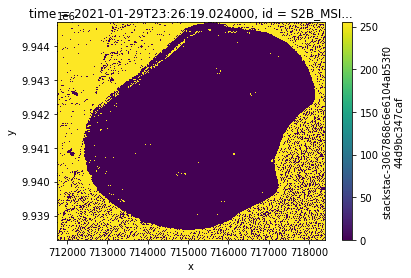

In [10]:
d = br[0]
d.plot.imshow()

In [18]:
d.rio.to_raster(aoi + ".tif", driver="COG", dtype="int16")

### Vectorise

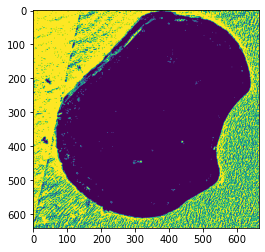

<AxesSubplot:>

In [20]:
with rasterio.open(aoi + '.tif') as xds:    
    band = xds.read()

show(band)

In [21]:
#Filter Water Band (0)
mask = band != 255
shapes = rasterio.features.shapes(band, mask=mask, transform=xds.transform)

#polygons = gpd.GeoDataFrame.from_features(geoms)
band = []
geometry = []
for shapedict, value in shapes:
    band.append(value)
    geometry.append(shape(shapedict))

# build the gdf object over the two lists
gdf = gpd.GeoDataFrame(
    {'band': band, 'geometry': geometry},
    crs=data.crs
)


In [22]:
gdf

,band,geometry
0,0.0,"POLYGON ((712575.000 9944695.000, 712575.000 9..."
1,0.0,"POLYGON ((713135.000 9944695.000, 713135.000 9..."
2,0.0,"POLYGON ((713495.000 9944695.000, 713495.000 9..."
3,0.0,"POLYGON ((713665.000 9944695.000, 713665.000 9..."
4,0.0,"POLYGON ((713735.000 9944695.000, 713735.000 9..."
...,...,...
7133,0.0,"POLYGON ((717885.000 9938305.000, 717895.000 9..."
7134,0.0,"POLYGON ((717925.000 9938315.000, 717935.000 9..."
7135,0.0,"POLYGON ((718175.000 9938325.000, 718185.000 9..."
7136,0.0,"POLYGON ((718255.000 9938295.000, 718255.000 9..."


### Extract Coastline (Largest Feature Shape Area)

In [23]:
gdf = gdf.to_crs(epsg=epsg)
gdf['area'] = gdf.geometry.area
gdf = gdf[gdf.area == gdf.area.max()]

### Coastline Polygon To Line

In [24]:
coastline = gdf.exterior #boundary

### Remove/Filter Noise

In [25]:
#

### Final Output

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

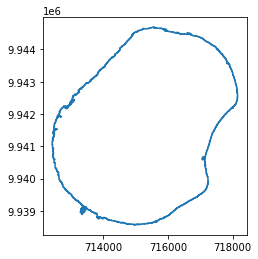

In [26]:
#cleanup
#os.remove(tin)
#os.remove(out)

coastline.to_file(aoi + "_shoreline_output.geojson", driver='GeoJSON')
coastline.plot()